# Import Statements

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl

# Parameters

In [42]:
source = 'combined'
sensor = 'pm25'
res_time = '1W'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
spikes_file = filepath_root+'hotspots/spikes_combined_{}.csv'.format(res_time)
time_high_file = filepath_root+'hotspots/hotspots_combined_temporalhigh_{}.pkl'.format(res_time)
time_low_file = filepath_root+'hotspots/hotspots_combined_temporallow_{}.pkl'.format(res_time)
space_high_file = filepath_root+'hotspots/hotspots_combined_spatialhigh_{}.pkl'.format(res_time)
space_low_file = filepath_root+'hotspots/hotspots_combined_spatiallow_{}.pkl'.format(res_time)

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Hotspots

In [43]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [44]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [45]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Hotspot_Counts

In [46]:
# shsp_high is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_high))

shsp_high = np.array(shsp_high)

# Find the number of locations with highest number of spatial high hotspots.

shsp_high_counts = {}
for col in df.columns:
    shsp_high_counts[col] = 0

for i in range(len(shsp_high)):
    hsp = shsp_high[i]
    shsp_high_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][hsp[1]]-df.loc[hsp[0]][loc]<50):
        shsp_high_counts[loc] += 1

df_counts_sph = pd.DataFrame.from_dict(shsp_high_counts,orient='Index',columns=['spatial_high'])

6


/state/partition1/job-29687160/ipykernel_376290/1545836603.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_high = np.array(shsp_high)


In [47]:
# shsp_low is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_low))

shsp_low = np.array(shsp_low)

# Find the number of locations with highest number of spatial low hotspots.

shsp_low_counts = {}
for col in df.columns:
    shsp_low_counts[col] = 0

for i in range(len(shsp_low)):
    hsp = shsp_low[i]
    shsp_low_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][loc]-df.loc[hsp[0]][hsp[1]]<50):
        shsp_low_counts[loc] += 1

df_counts_spl = pd.DataFrame.from_dict(shsp_low_counts,orient='Index',columns=['spatial_low'])

2


/state/partition1/job-29687160/ipykernel_376290/81904359.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_low = np.array(shsp_low)


In [48]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_high[col])
print(num_hsps)

thsp_high_counts = {key:len(value) for key,value in thsp_high.items()}

df_counts_tmh = pd.DataFrame.from_dict(thsp_high_counts,orient='Index',columns=['temporal_high'])

204


In [49]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_low[col])
print(num_hsps)

thsp_low_counts = {key:len(value) for key,value in thsp_low.items()}

df_counts_tml = pd.DataFrame.from_dict(thsp_low_counts,orient='Index',columns=['temporal_low'])

df_counts = df_counts_sph.join(other=[df_counts_spl, df_counts_tmh, df_counts_tml])

3


In [11]:
df_counts.to_csv('hotspot_counts_combined_{}.csv'.format(res_time))

## Results

In [17]:
col4 = list(df_counts.sort_values(by=['temporal_low'], ascending=False)[:10].index)

In [18]:
col3 = list(df_counts.sort_values(by=['spatial_low'], ascending=False)[:10].index)

In [19]:
locs.loc['E486']

UDID         4067187ca8d84d1584997699fc25e486
Latitude                            28.536617
Longitude                           77.372281
Address                           Kailas Home
Location                     Noida Sector 104
Type                                 Kaiterra
Name: E486, dtype: object

In [20]:
col2 = list(df_counts.sort_values(by=['temporal_high'], ascending=False)[:10].index)

In [21]:
col1 = list(df_counts.sort_values(by=['spatial_high'], ascending=False)[:10].index)

In [25]:
df_table_top_10 = pd.DataFrame([col1,col2,col3,col4]).transpose()
df_table_top_10.columns=['Spatial High', 'Temporal High', 'Spatial Low', 'Temporal Low']
df_table_top_10.to_csv('table_top_10.csv',sep='&')

In [18]:
locs.loc['C0A7']

UDID         9a4b19a6bd284bfdb20f43ca1aa4c0a7
Latitude                            28.415079
Longitude                            77.04353
Address                               Nischal
Location                   Gurugram Sector 49
Type                                 Kaiterra
Name: C0A7, dtype: object

In [19]:
locs.loc['4BE7']

UDID         482827c4bf5d4224b4368458e1a94be7
Latitude                             28.53287
Longitude                           77.217112
Address                      Senjuti Banerjee
Location                        Malviya Nagar
Type                                 Kaiterra
Name: 4BE7, dtype: object

# Common Occurance

In [20]:
co_thsh = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsh += 1
co_thsh

3202

In [21]:
co_tlsh = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsh += 1
co_tlsh

477

In [22]:
co_thsl = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsl += 1
co_thsl

141

In [23]:
co_tlsl = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsl += 1
co_tlsl

156

# Inferences: Temporal Hotspots

In [24]:
time_interest_locs = set(df_counts.sort_values(by=['temporal_high'], ascending=False)[:10].index).intersection(\
                            set(df_counts.sort_values(by=['temporal_low'], ascending=False)[:10].index))

/state/partition1/job-29563108/ipykernel_1990446/3921831146.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-29563108/ipykernel_1990446/3921831146.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


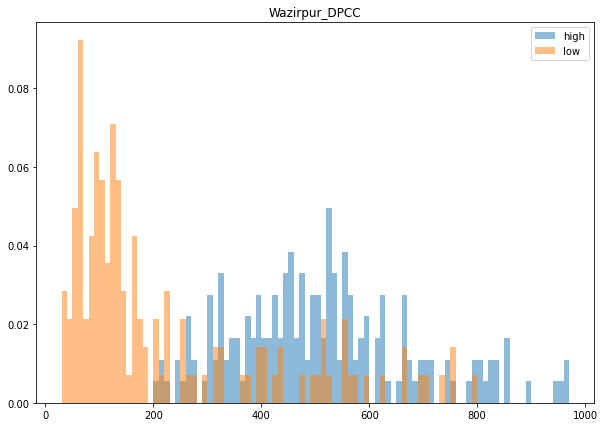

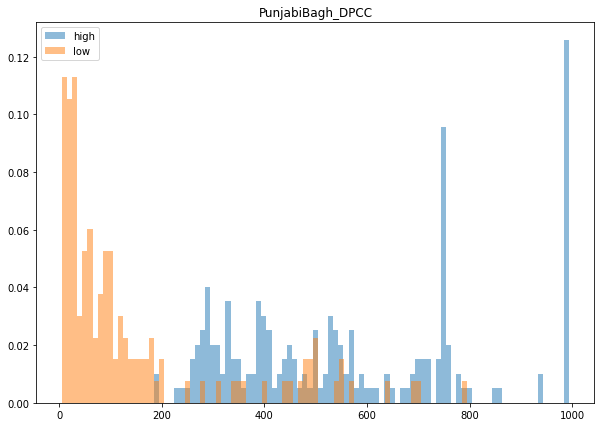

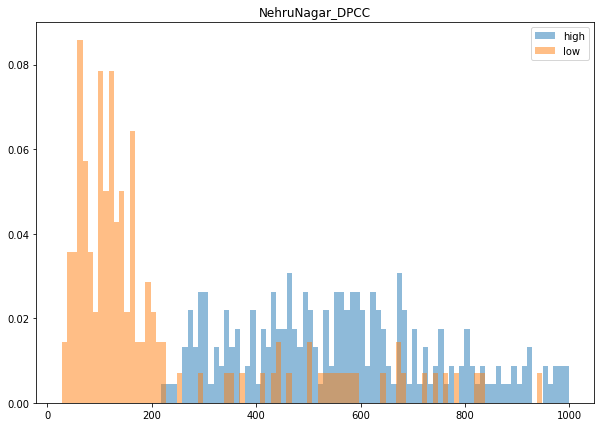

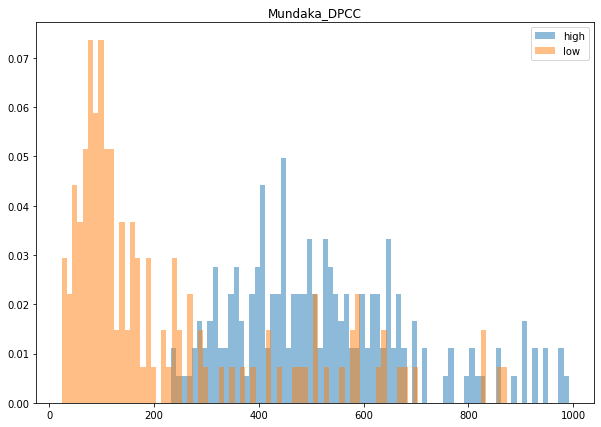

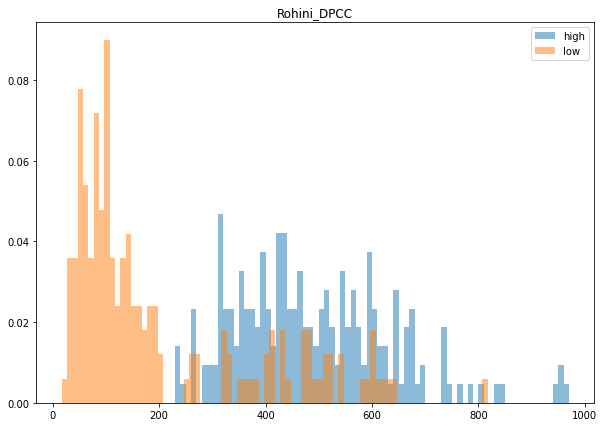

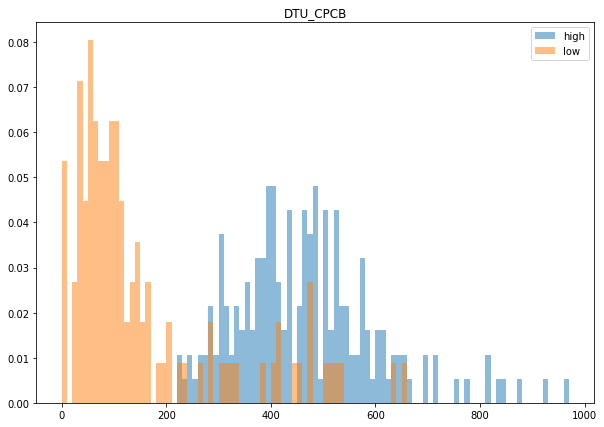

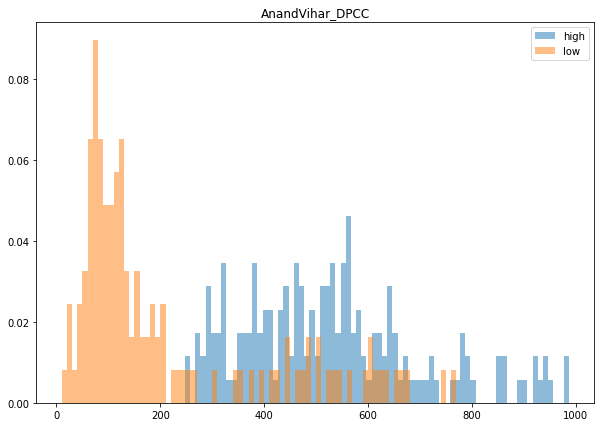

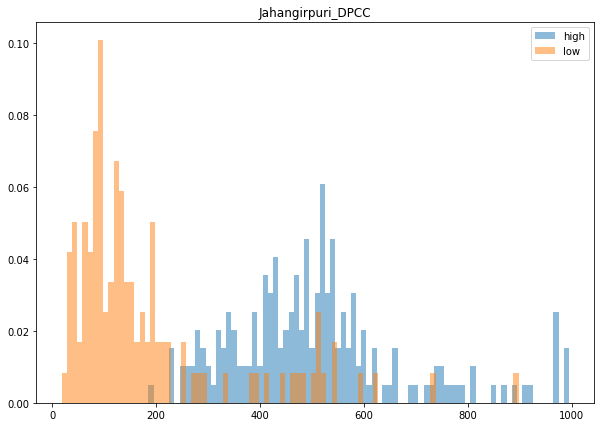

In [25]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_vals = np.array(high_hsps)[:,1]
    low_vals = np.array(low_hsps)[:,1]
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
                bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
                bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

In [26]:
high_pol_locs = set(df_counts.sort_values(by=['spatial_high'], ascending=False)[:10].index).intersection\
(time_interest_locs)

In [27]:
for location in high_pol_locs:
    print(location, df[location].mean(), df[location].std())

Wazirpur_DPCC 118.7319209382739 117.74383613843602
PunjabiBagh_DPCC 102.9687230506221 112.46336005345107
NehruNagar_DPCC 110.23469715128607 121.9303469679721
Mundaka_DPCC 116.55957468457468 120.17610553916866
AnandVihar_DPCC 122.05786582787057 120.01145647200977
Jahangirpuri_DPCC 119.32124772355826 114.31261743442865


In [28]:
print(df['Jahangirpuri_DPCC'].mean(), df['Jahangirpuri_DPCC'].std())

119.32124772355826 114.31261743442865


/state/partition1/job-29563108/ipykernel_1990446/433554290.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-29563108/ipykernel_1990446/433554290.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


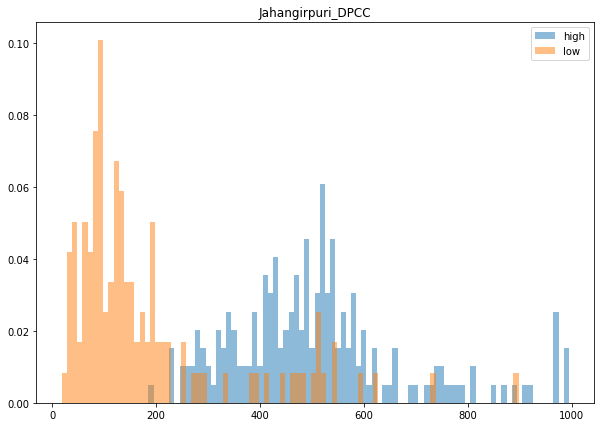

In [29]:
location = 'Jahangirpuri_DPCC'
high_hsps = thsp_high[location]
low_hsps = thsp_low[location]
high_vals = np.array(high_hsps)[:,1]
low_vals = np.array(low_hsps)[:,1]
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title(location)
plt.legend()

In [30]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.764705882352941

# Compare with only Government Data Hotspots

In [ ]:
df_gov = pd.read_csv('govhotspot_counts_3H.csv',index_col=0)
df_com = pd.read_csv('hotspot_counts_3H.csv',index_col=0)
df_gov.columns = df_gov.columns + '_gov'
df_com.columns = df_com.columns + '_com'

In [36]:
df_hotspots = df_com.join([df_gov])

In [ ]:
df_hotspots.sort_values(by=['spatial_low_gov'], ascending=False)[:10]

In [ ]:
df_hotspots.sort_values(by=['spatial_low_com'], ascending=False)[:10]

In [ ]:
# df_hotspots

In [38]:
shsp_high

array([[Timestamp('2018-05-01 12:00:00+0530', tz='pytz.FixedOffset(330)'),
        'MandirMarg_DPCC', list([])],
       [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        'AyaNagar_IMD', list([])],
       [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        'BurariCrossing_IMD', list([])],
       ...,
       [Timestamp('2020-10-30 06:00:00+0530', tz='pytz.FixedOffset(330)'),
        'DTU_CPCB', list(['Rohini_DPCC', 'Jahangirpuri_DPCC'])],
       [Timestamp('2020-10-31 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        'Jahangirpuri_DPCC',
        list(['PunjabiBagh_DPCC', 'SoniaVihar_DPCC'])],
       [Timestamp('2020-10-31 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        'VivekVihar_DPCC',
        list(['AnandVihar_DPCC', 'Patparganj_DPCC', 'ITO_CPCB'])]],
      dtype=object)

In [ ]:
shsp_high[:,2]

# Inferences: Spatial Hotspots

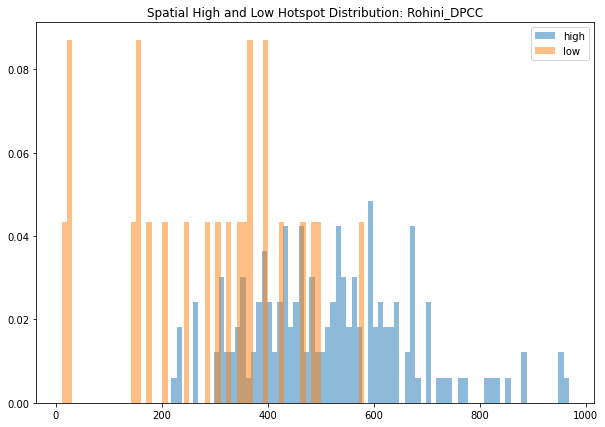

In [31]:
val_high = []
val_low = []
station = 'Rohini_DPCC'
for i in range(len(shsp_high[shsp_high[:,1]==station])):
    hsp_loc = shsp_high[shsp_high[:,1]==station][i][1]
    hsp_time = shsp_high[shsp_high[:,1]==station][i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_high.append(val)
for i in range(len(shsp_low[shsp_low[:,1]==station])):
    hsp_loc = shsp_low[shsp_low[:,1]==station][i][1]
    hsp_time = shsp_low[shsp_low[:,1]==station][i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_low.append(val)
    
high_vals = np.array(val_high)
low_vals = np.array(val_low)
    
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title('Spatial High and Low Hotspot Distribution: '+station)
plt.legend()

In [32]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.30434782608695654

In [33]:
low_pol_locs = list(df_counts.sort_values(by=['spatial_low'], ascending=False)[:10].index)

In [34]:
for location in low_pol_locs:
    print(location, df[location].mean(), df[location].std())

AyaNagar_IMD 76.84957437407954 74.40286671106813
NSIT_CPCB 97.34316835343594 76.9548058005288
E486 99.52984933938885 94.37376136873213
Shadipur_CPCB 97.25035391064114 89.43057488400045
IHBAS_CPCB 95.02716642823081 86.65383016484078
Pusa_IMD 76.98951550093561 77.75367271111175
VivekVihar_DPCC 101.20468193741802 104.73987822865895
SoniaVihar_DPCC 99.4087119924457 97.5324365214323
DTU_CPCB 105.32428925659244 102.30233408580187
LodhiRoad_IMD 77.3137139470565 72.47032819824548


In [35]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

AyaNagar_IMD 149.8997157622739 81.14823993616653
NSIT_CPCB 207.33106557377047 123.2164062471004
E486 224.10331532708292 111.9819174569726
Shadipur_CPCB 200.206484375 126.54577570030503
IHBAS_CPCB 173.38167400881056 120.22576021514352
Pusa_IMD 151.10470588235293 90.18459702763684
VivekVihar_DPCC 84.1590909090909 81.53397817330965
SoniaVihar_DPCC 272.1924719101124 126.89156417741827
DTU_CPCB 187.89700598802392 145.6077596755368
LodhiRoad_IMD 203.97253846153848 111.0527389923018


In [36]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

Wazirpur_DPCC 526.9283489096573 159.69124361585352
PunjabiBagh_DPCC 580.6708333333333 265.7238003225907
NehruNagar_DPCC 494.70859133126936 177.56229971136264
Mundaka_DPCC 518.9799349240781 165.81056013400436
AnandVihar_DPCC 550.9666246851385 173.90898634343975
Jahangirpuri_DPCC 499.4125 174.20974835954212


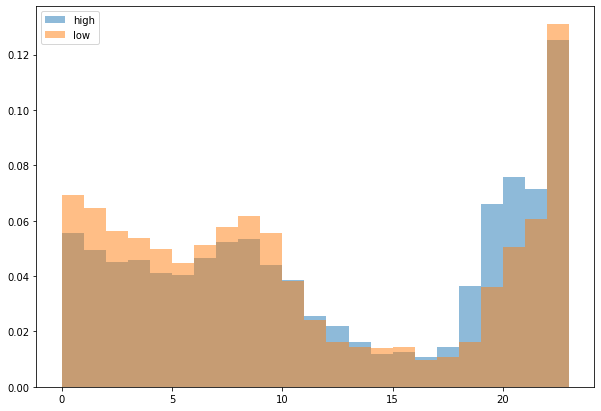

In [37]:
time_high = []
for i in range(len(shsp_high)):
    time_high.append(shsp_high[i][0].time().hour)
time_low = []
for i in range(len(shsp_low)):
    time_low.append(shsp_low[i][0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(time_high, weights=np.ones(len(time_high))/len(time_high), \
                 bins=range(int(min(time_high)),int(max(time_high)) + 1, 1), cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(time_low, weights=np.ones(len(time_low))/len(time_low), \
                 bins=range(int(min(time_low)),int(max(time_low)) + 1, 1), cumulative=False,alpha=0.5,label='low')
plt.legend()

# Duration for Temporal Hotspots

/state/partition1/job-29563108/ipykernel_1990446/1640478924.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_time_wins = np.array(high_hsps)[:,2]
/state/partition1/job-29563108/ipykernel_1990446/1640478924.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_time_wins = np.array(low_hsps)[:,2]


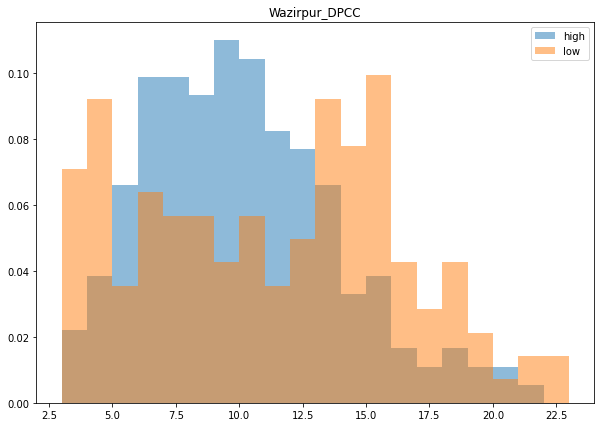

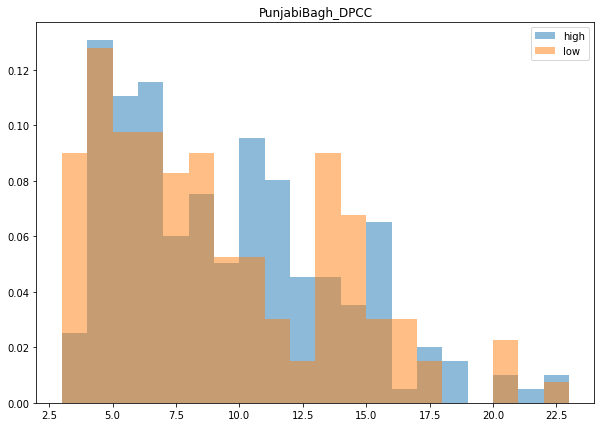

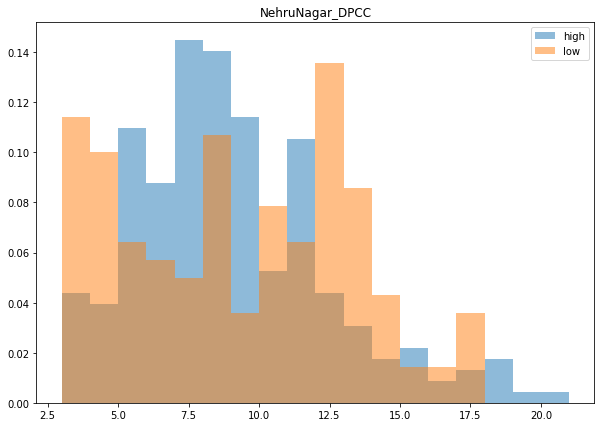

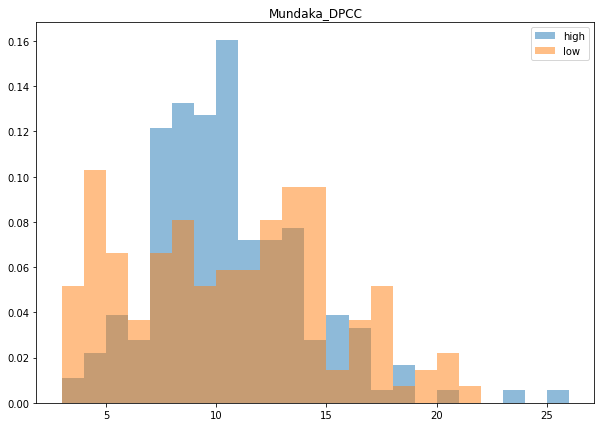

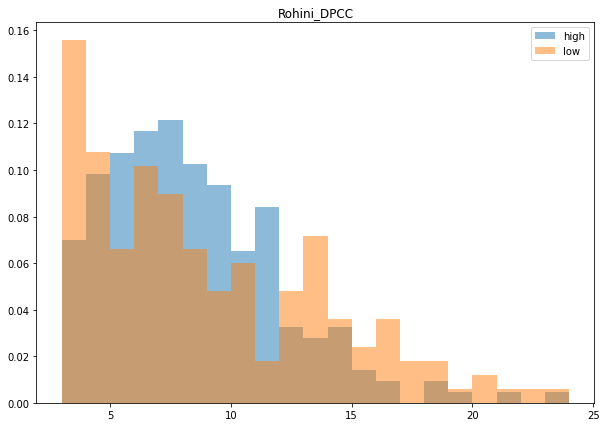

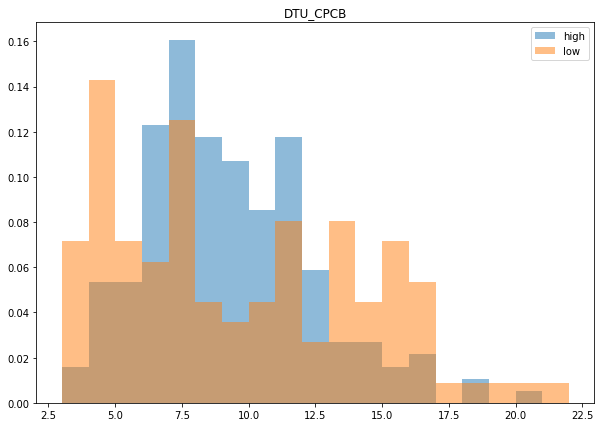

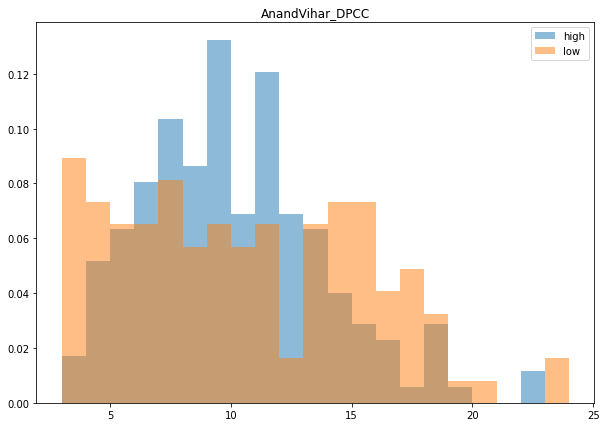

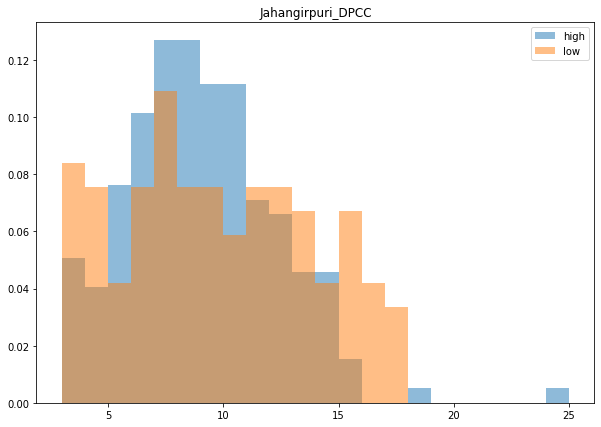

In [38]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_time_wins = np.array(high_hsps)[:,2]
    f = lambda x: len(x)
    high_ints = np.array([f(xi) for xi in high_time_wins])
    low_time_wins = np.array(low_hsps)[:,2]
    low_ints = np.array([f(xi) for xi in low_time_wins])
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_ints, weights=np.ones(len(high_ints))/len(high_ints),\
                bins=range(int(min(high_ints)),int(max(high_ints)) + 1, 1),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_ints, weights=np.ones(len(low_ints))/len(low_ints),\
                bins=range(int(min(low_ints)),int(max(low_ints)) + 1, 1),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

# Radius of Spatial Hotspots

In [39]:
# nn_dict = {}
# for col in df.columns:
#     dist_df = distances.loc[col].sort_values().dropna()
#     nn_dict[col] = dist_df

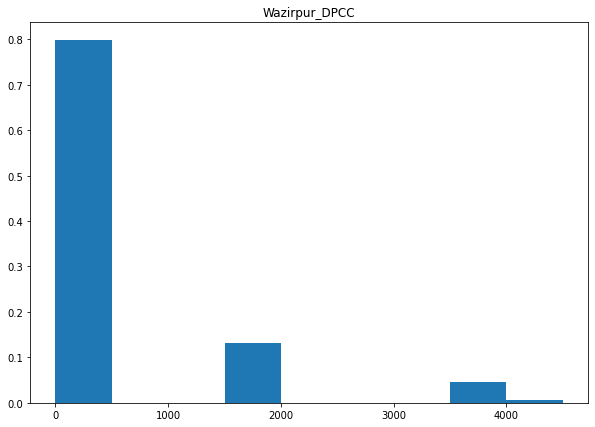

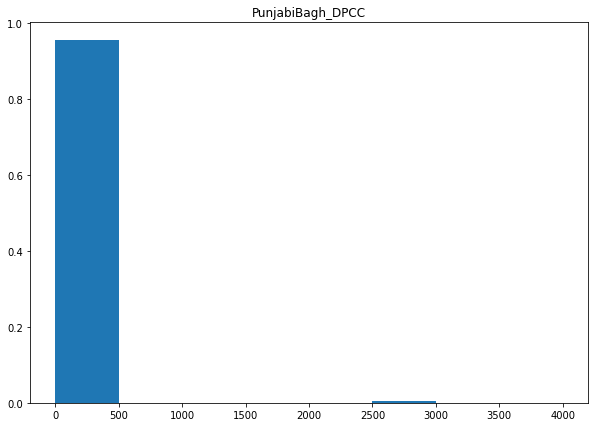

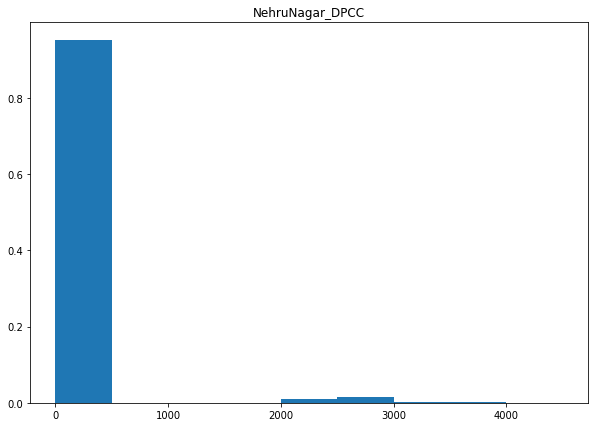

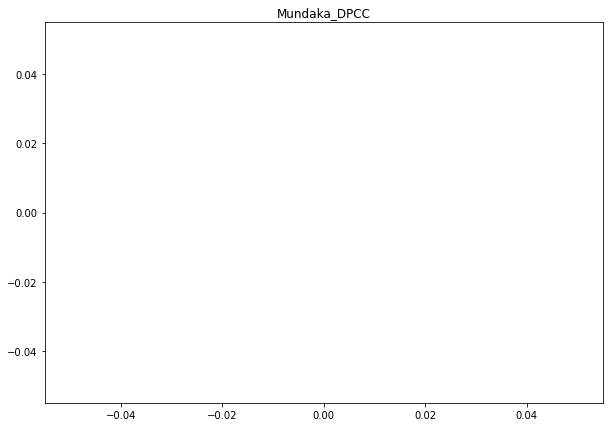

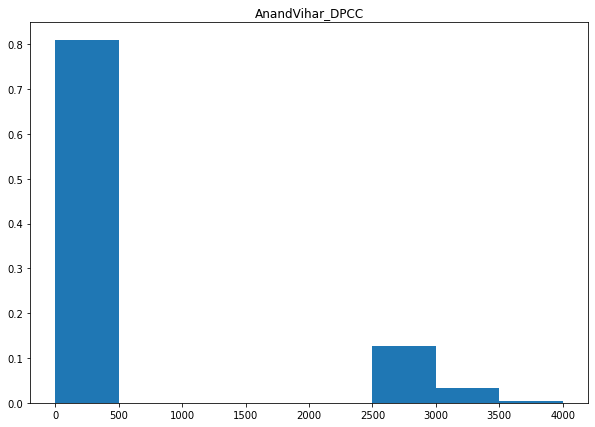

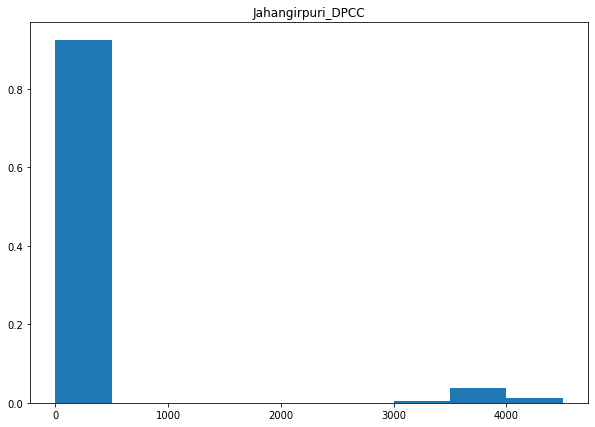

In [40]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][cen]-df.loc[time][stn]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

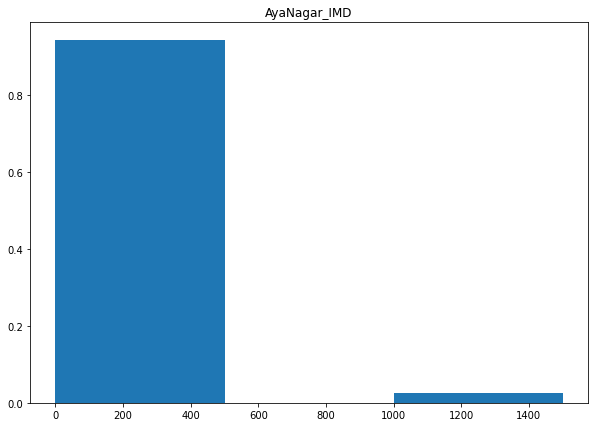

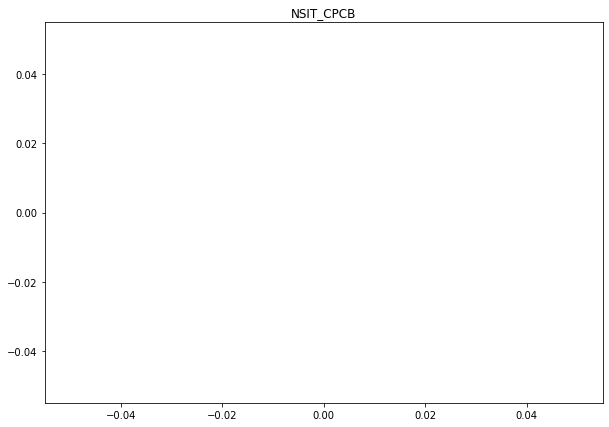

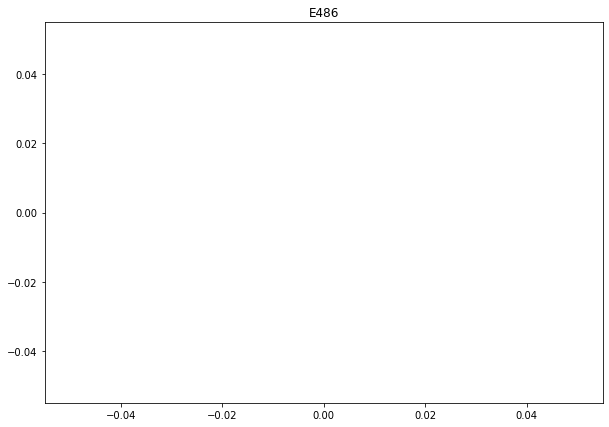

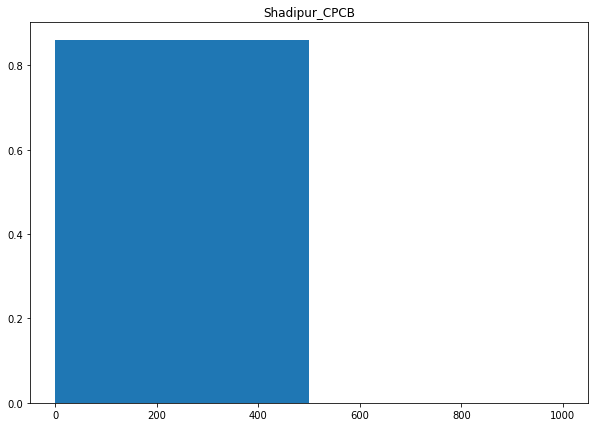

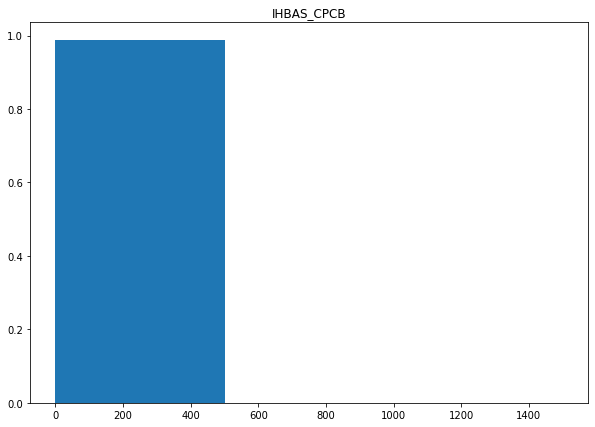

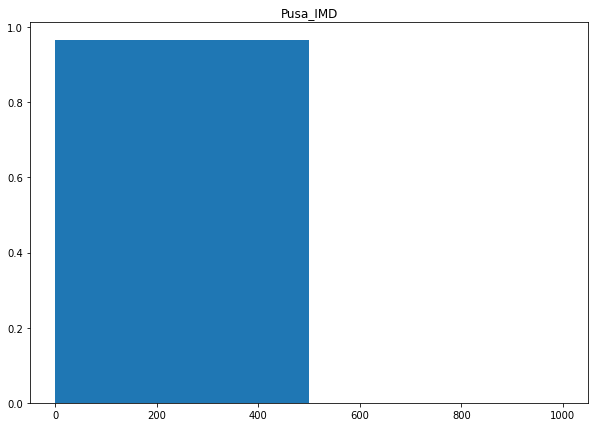

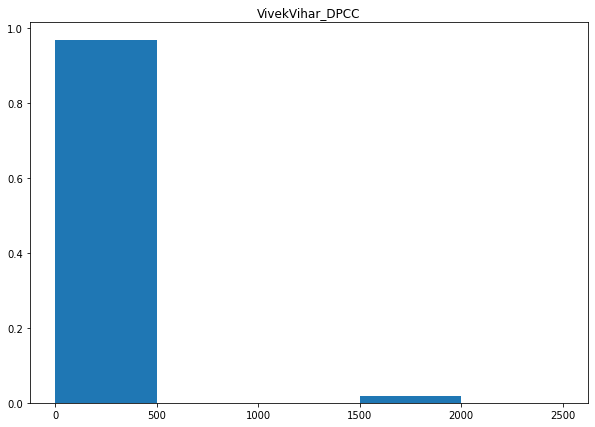

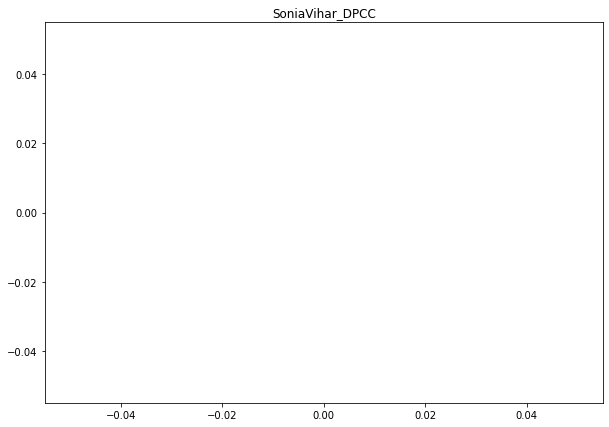

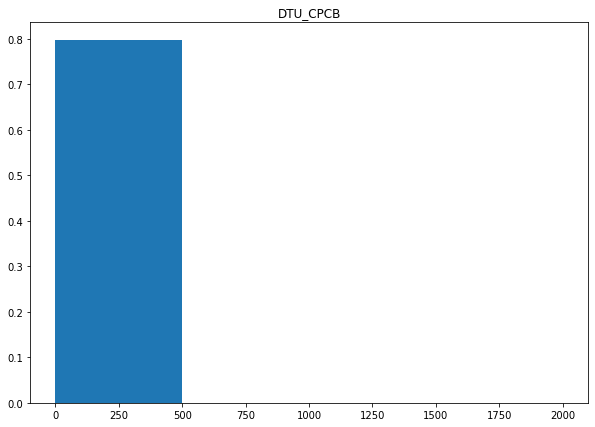

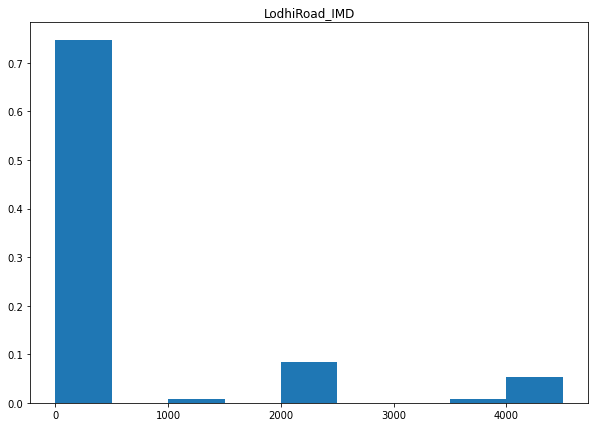

In [41]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][stn]-df.loc[time][cen]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

# Magnitude of Temporal Hotspots (Longitudnal)

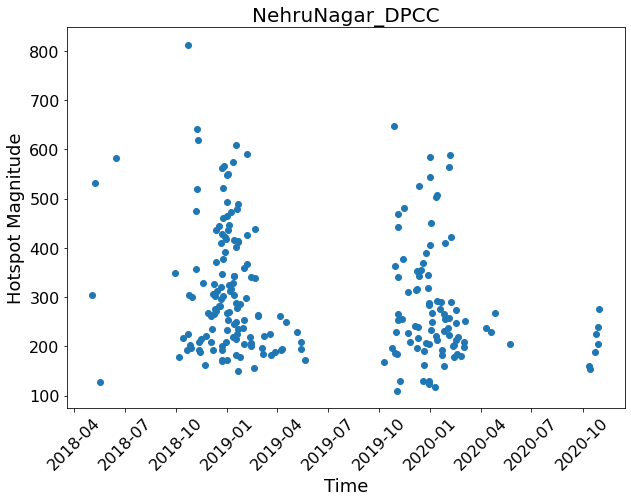

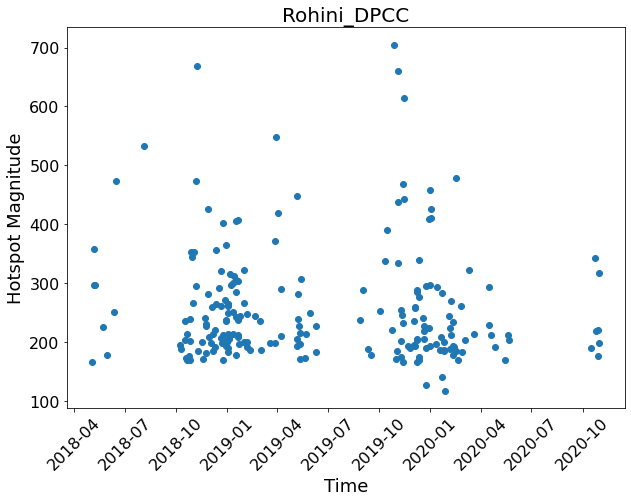

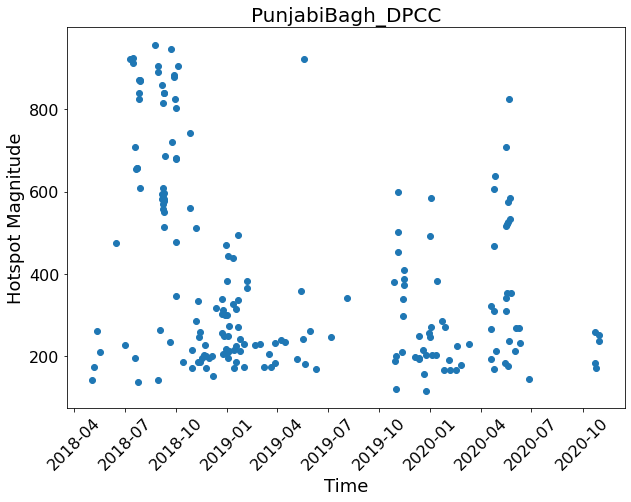

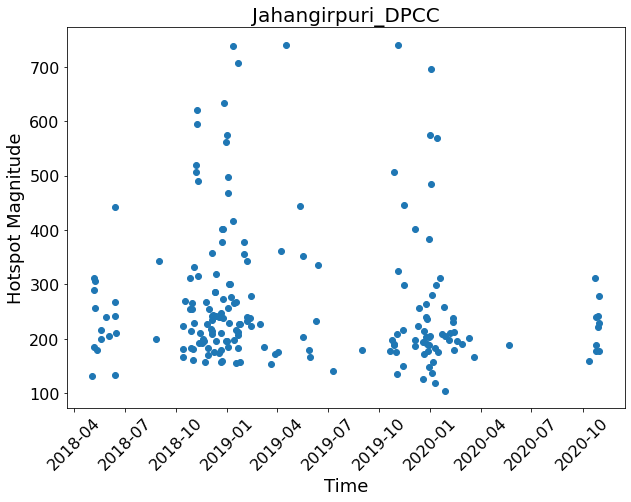

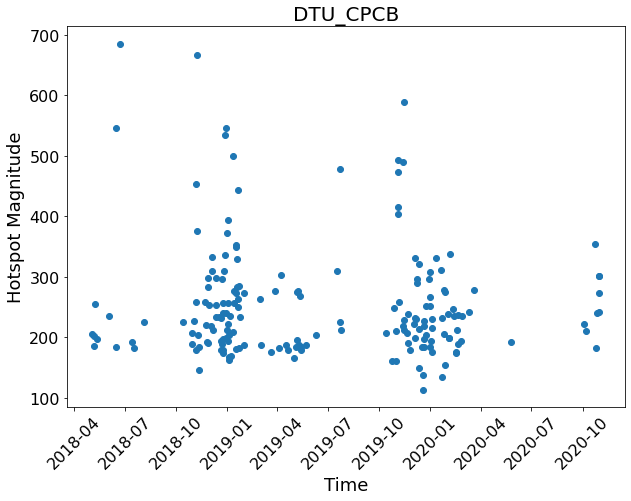

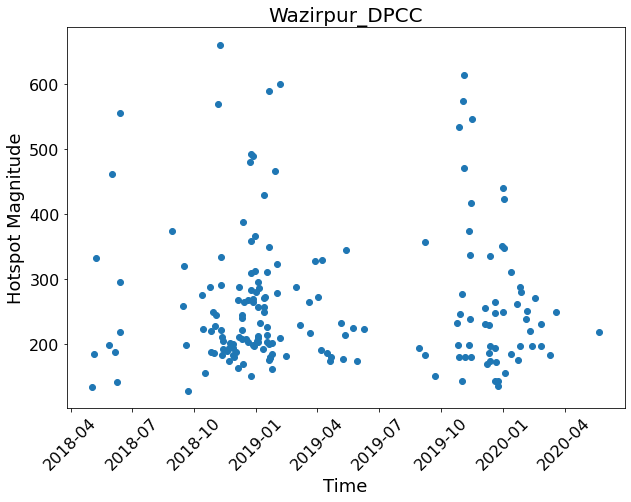

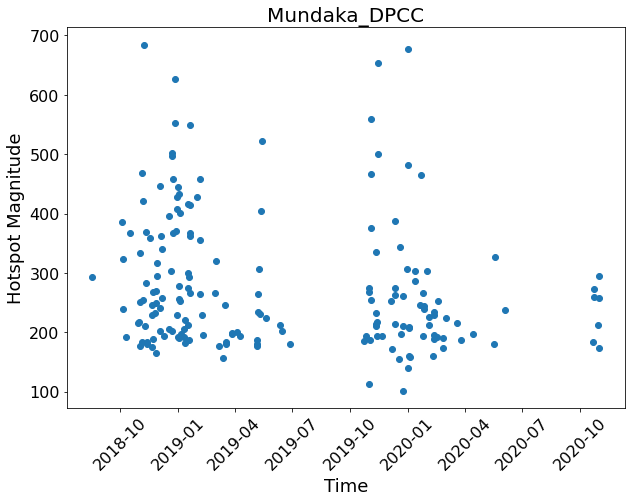

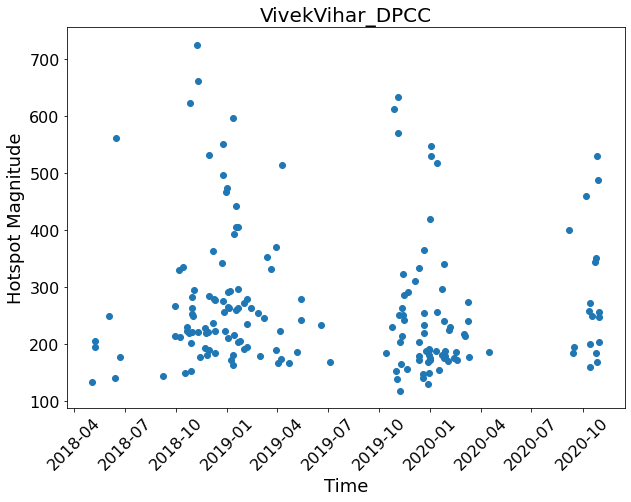

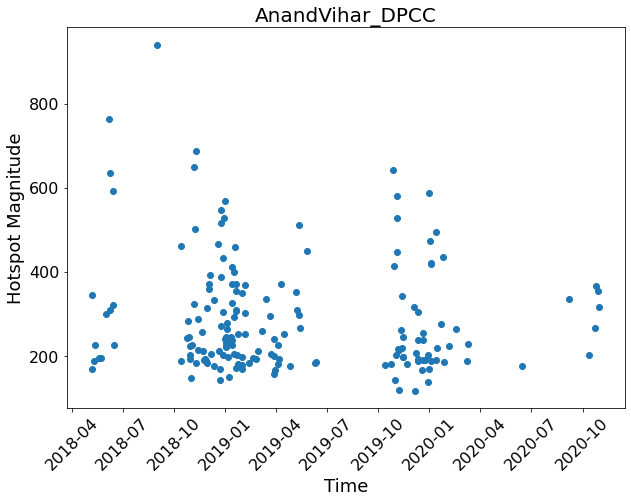

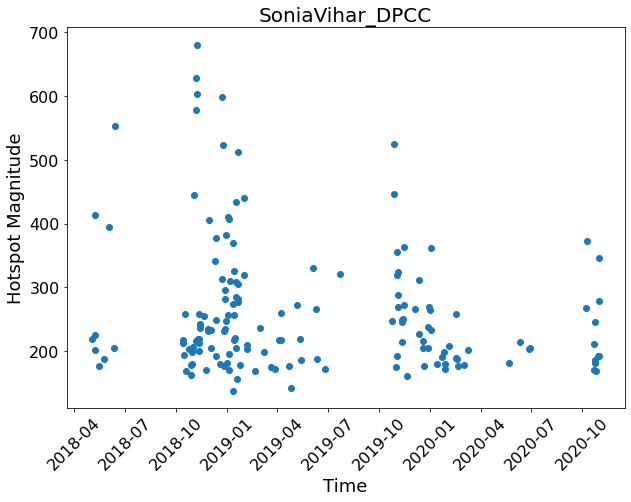

In [45]:
plt.rcParams.update({'font.size': 16})
for station in df_counts.sort_values(by=['temporal_high'], ascending=False)[:10].index:
    hsp_mag = []
    x = []
    for i in range(len(thsp_high[station])):
        hsp = thsp_high[station][i]
        ts_le = hsp[2][0]
        ts_rb = hsp[2][-1]
        wind = len(hsp[2])
        ts = hsp[0]
        idx = list(df[station].index)
        idx_le = idx.index(ts_le)
        idx_rb = idx.index(ts_rb)
        idx_re = idx_rb+5*wind
        idx_lb = idx_le-5*wind
        idx_lb = max(0,idx_lb)
        idx_re = min(idx_re,len(df))
        idxs = np.concatenate((np.array(idx)[idx_lb:idx_le+1],np.array(idx)[idx_rb:idx_re+1]))
        y = df[station].loc[idxs].values
        avg_y = np.nanmean(y)
#         x = range(len(y))
#         fig, ax = plt.subplots(figsize=(5,3.5))
#         plt.plot(x,y)
#         plt.axhline(y=np.nanmean(y), linestyle='--', alpha=0.5)
        
#         hsp_idx = np.where(idxs==ts)[0][0]
#         diwali_idx = np.where(idxs==diwali_ts)[0][0]
#         plt.scatter(x[hsp_idx],y[hsp_idx],s=100)
#             plt.scatter(x[diwali_idx],y[diwali_idx],s=400,alpha=0.1,color='r')
#         plt.axvline(x=diwali_idx, linestyle='--', alpha=0.5,color='r')
        # ax = plt.gca()
        hsp_mag.append(hsp[1] - avg_y)
        x.append(ts)
#         ax.axes.xaxis.set_ticks([])
#         plt.xlabel('Time')
#         plt.ylabel('PM2.5')
#         plt.title(station)
#         plt.savefig("temporal_hotspot.png")
#     plt.figure()
#     plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(10,7))
    y = np.array(hsp_mag)
    plt.scatter(x,y)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Hotspot Magnitude',fontsize=18)
    plt.title(station,fontsize=20)
    plt.xticks(rotation = 45)
    plt.show()

# Magnitude of Spatial Hotspots (Longitudinal)

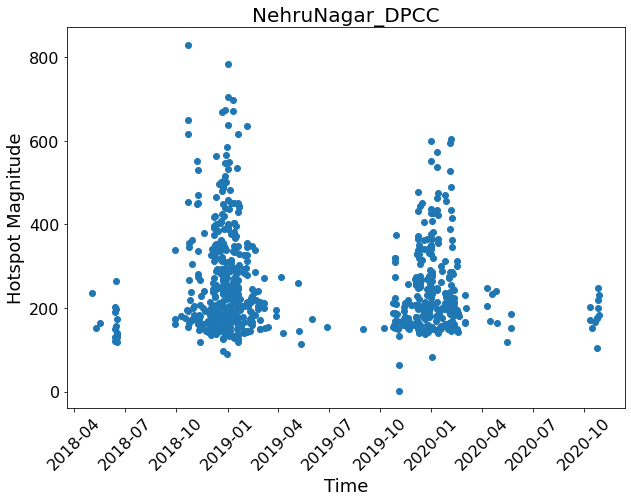

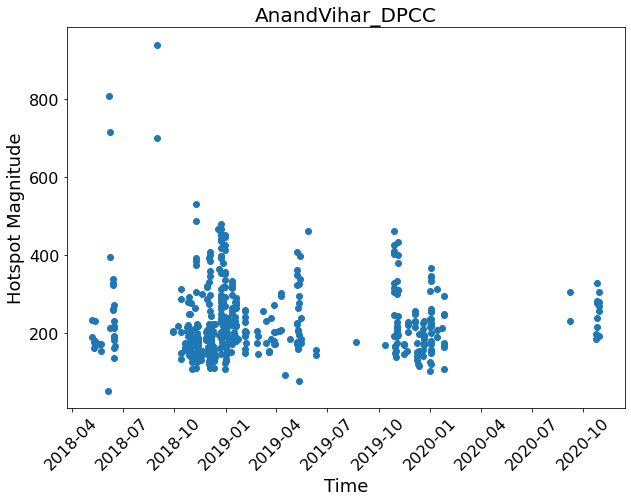

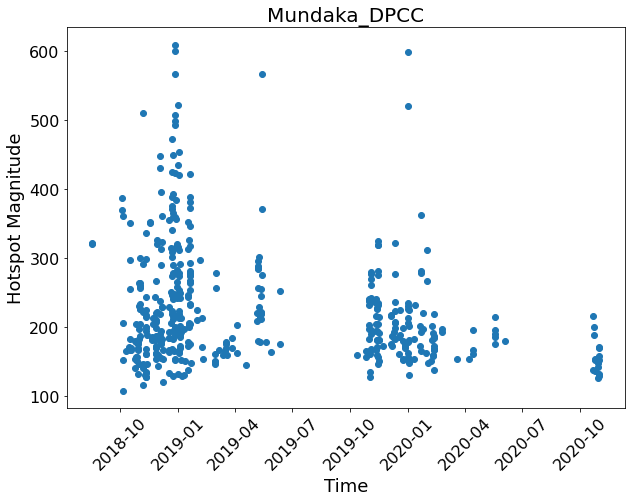

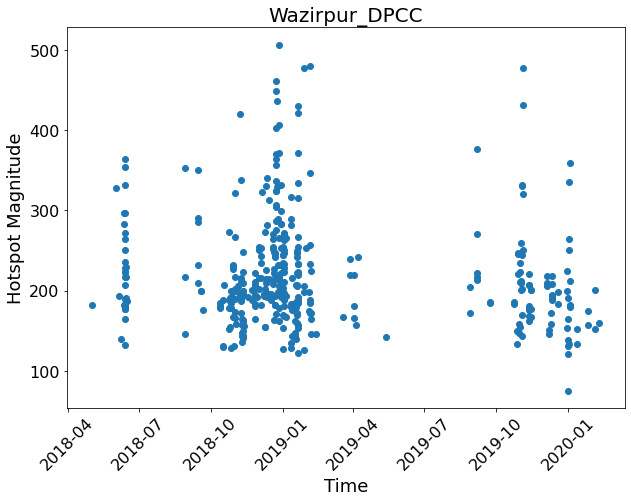

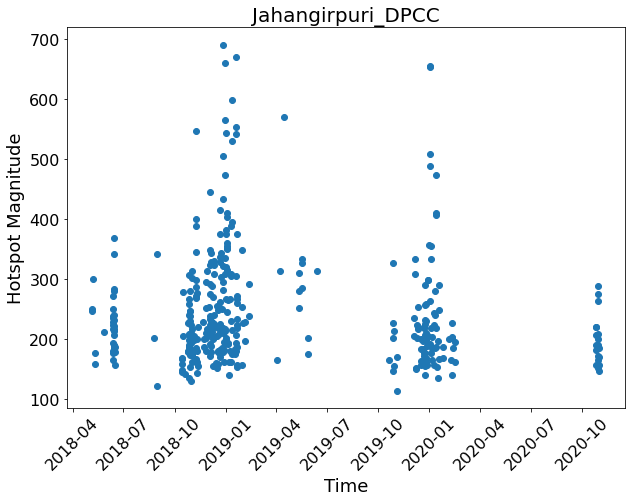

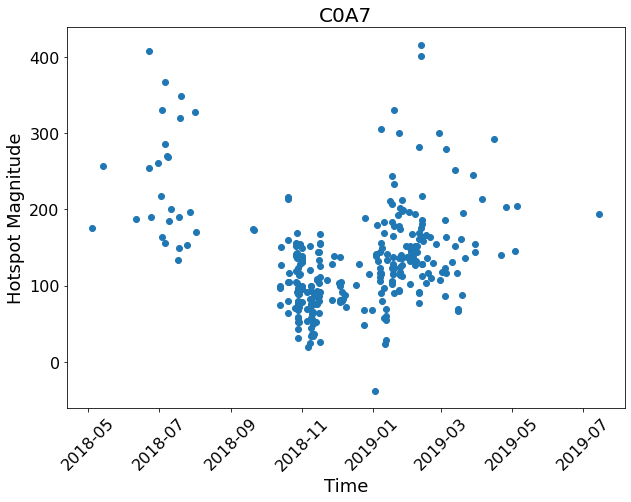

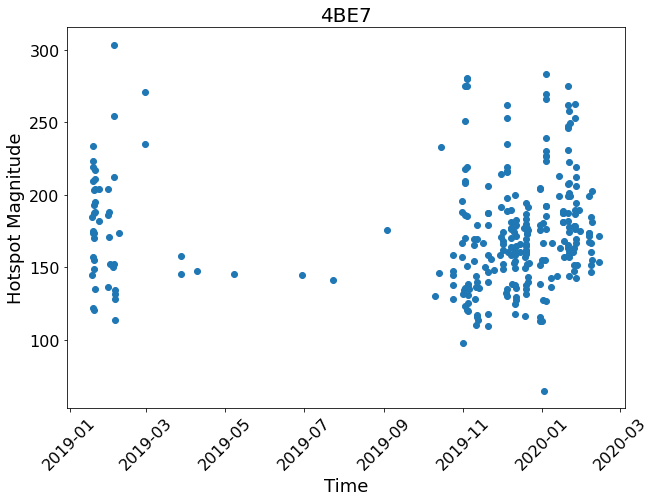

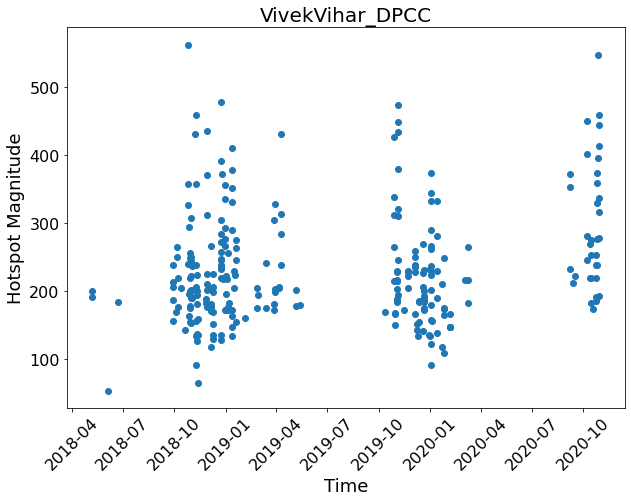

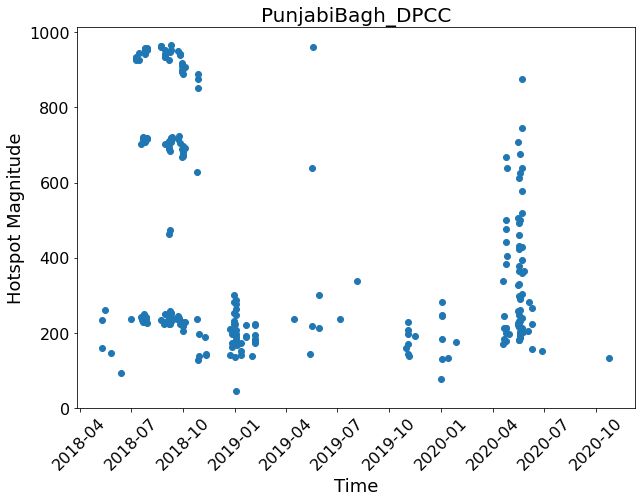

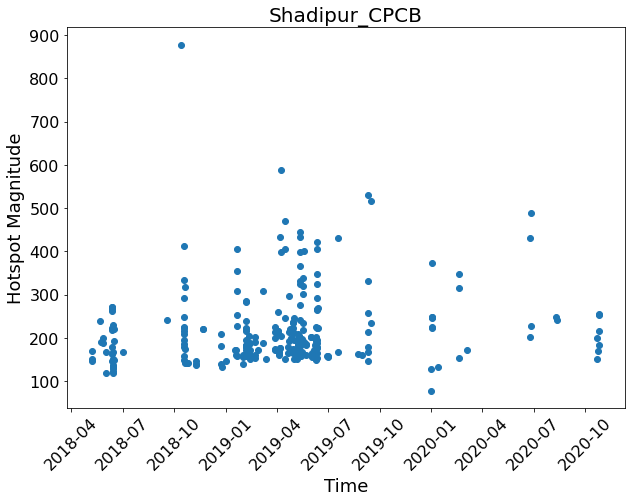

In [46]:
plt.rcParams.update({'font.size': 16})
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df
for station in df_counts.sort_values(by=['spatial_high'], ascending=False)[:10].index:
    hsp_mag = []
    x = []
    for i in range(len(shsp_high)):
        hsp = shsp_high[i]
        if(station==hsp[1] or station in hsp[2]):
            ts = hsp[0]
            df_snap = df.loc[ts].dropna()
            loc_list = list(df_snap.index)
            available_locs = [x for x in loc_list if x != hsp[0]]
            sp_nh = list(nn_dict[hsp[1]][nn_dict[hsp[1]]<20*1000].index)
#             print(sp_nh)
            avg_locs = [x for x in sp_nh if x in available_locs]
            avg_reading = df_snap[avg_locs].mean()
            hsp_mag.append(df.loc[ts][hsp[1]] - avg_reading)
            x.append(ts)

    fig, ax = plt.subplots(figsize=(10,7))
    y = np.array(hsp_mag)
    plt.scatter(x,y)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Hotspot Magnitude',fontsize=18)
    plt.title(station,fontsize=20)
    plt.xticks(rotation = 45)
    plt.show()

In [44]:
df_counts

,spatial_high,spatial_low,temporal_high,temporal_low
113E,108,12,65,63
1FD7,15,42,6,2
20CA,16,35,37,20
2E9C,40,28,25,13
3ACF,0,0,1,0
498F,0,0,0,0
4BE7,297,11,69,55
56C3,19,5,30,25
5D7A,1,31,3,3
603A,47,13,31,23
